In [2]:
'''
Subject : Vocal Separation 


This notebook demonstrates a simple technique for separating vocals (and other sporadic foreground signals) from accompanying instrumentation.

This is based on the “REPET-SIM” method of Rafii and Pardo, 2012, but includes a couple of modifications and extensions:
    FFT windows overlap by 1/4, instead of 1/2

    Non-local filtering is converted into a soft    mask by Wiener filtering. This is similar in spirit to the soft-masking method used by Fitzgerald, 2012, but is a bit more numerically stable in practice.

'''

'\nSubject : Vocal Separation \n\n\nThis notebook demonstrates a simple technique for separating vocals (and other sporadic foreground signals) from accompanying instrumentation.\n\nThis is based on the “REPET-SIM” method of Rafii and Pardo, 2012, but includes a couple of modifications and extensions:\n    FFT windows overlap by 1/4, instead of 1/2\n\n    Non-local filtering is converted into a soft    mask by Wiener filtering. This is similar in spirit to the soft-masking method used by Fitzgerald, 2012, but is a bit more numerically stable in practice.\n\n'

In [3]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display

In [4]:
#Load an example with vocals.

y, sr = librosa.load(librosa.ex('fishin'), duration=120)

#And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

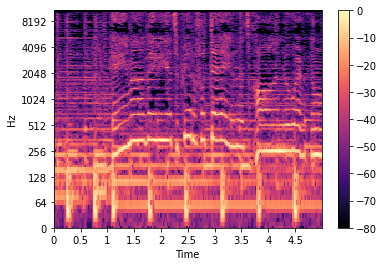

In [5]:
#Plot a 5-second slice of the spectrum

idx = slice(*librosa.time_to_frames([10,15], sr=sr))
fig, ax = plt.subplots()

img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
    y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img,ax=ax)


In [6]:
'''

The wiggly(구불구불한) lines above are due to the vocal component. Our goal is to separate them from the accompanying[반주] instrumentation[]].

'''

# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.


S_filter = librosa.decompose.nn_filter(S_full,
                                aggregate=np.median,
                                metric='cosine',
                                width=int(librosa.time_to_frames(2,sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)


In [7]:
'''
The raw filter output can be used as a mask, but it sounds better if we use soft-masking.
'''

# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation

margin_i, margin_v = 2,10
power  =2


mask_i = librosa.util.softmask(S_filter,
                                margin_i * (S_full - S_filter), power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                                margin_v * S_filter, power=power)


#Once we have the masks, simply multiply them with the input spectrum 
#to separate the components 

S_foreground = mask_v * S_full
S_background = mask_i * S_full


In [8]:
S_foreground

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.4428925e-03,
        2.9744650e-03, 9.1548366e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2118140e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.4660054e-05],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.0634073e-05,
        5.4493894e-06, 1.2627805e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.5781664e-05,
        0.0000000e+00, 1.2579499e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.5539072e-05,
        5.4715983e-06, 1.2617903e-02]], dtype=float32)

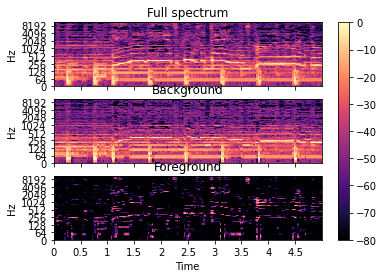

In [9]:
'''
Plot the same slice, but separated into its foreground and background
'''

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)

img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:,idx], ref=np.max),
y_axis='log', x_axis='time', sr=sr,ax=ax[0])


ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx],ref=np.max),
y_axis='log', x_axis='time', sr=sr, ax=ax[1])

ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx],ref=np.max),
y_axis='log', x_axis='time', sr=sr, ax=ax[2])

ax[2].set(title='Foreground')
fig.colorbar(img,ax=ax)

In [10]:
'''
Recover the foreground audio from the masked spectrogram. To do this, we’ll need to re-introduce the phase information that we had previously set aside.
'''

y_foreground = librosa.istft(S_foreground * phase)

In [11]:
y_foreground

array([-3.2580226e-07,  3.2554627e-07, -3.2507717e-07, ...,
       -1.2819256e-02, -8.2674278e-03, -3.9617517e-03], dtype=float32)